<a href="https://colab.research.google.com/github/wakii/ML_Programming/blob/master/ex5-imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB

In [78]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/ex4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [77]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/content/data/imdb_sample/texts.csv'),
 PosixPath('/content/data/imdb_sample/data_lm.pkl'),
 PosixPath('/content/data/imdb_sample/data_save.pkl')]

It only contains one csv file, let's have a look at it.

In [68]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


- text data 가져오기
- pos, neg 로 text 들이 labelling 되어 있다.

In [34]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [69]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

- `TextDataBunch` : 자연어처리를 위한 tokenization과 numericalization을 수행해준다.

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [0]:
data_lm.save()

- pre-processing 한 databunch를 저장해둔다. 

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [0]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [76]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

FileNotFoundError: ignored

- tokenization 처리 된 값들

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [39]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

- vocab : data 내의 unique한 token 값들
- vocab.itos : 각 token에 대한 id들이 저장되어있다.

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [40]:
data.train_ds[0][0]

Text xxbos xxmaj for me the only reason for having a look at this remake was to see how bad and funny it could be . xxmaj there was no doubt about it being funny and bad , because i had seen " xxmaj voyna i mir " ( 1968 ) . xxmaj shall we begin ? xxmaj here we go ... 
 
  xxmaj robert xxmaj dornhelm & xxmaj brendan xxmaj donnison 's xxmaj xxunk xxmaj bezukhov - a lean fellow that lacks the depth of the original ; xxmaj robert xxmaj dornhelm & xxmaj brendan xxmaj donnison 's xxmaj natasha xxmaj xxunk - a scarecrow , her image can cause xxunk ; xxmaj robert xxmaj dornhelm & xxmaj brendan xxmaj donnison 's xxmaj xxunk xxmaj bolkonsky - an xxup ok incarnation which , like the lean fellow ( xxunk . above ) , lacks depth of a xxmaj russian soul and " struggle within " ; xxmaj robert xxmaj dornhelm & xxmaj brendan xxmaj donnison 's xxmaj xxunk - a rather xxunk leader ; xxmaj robert xxmaj dornhelm & xxmaj brendan xxmaj donnison 's xxmaj prince xxmaj bolkonsky - a turd with an xxmaj english fac

But the underlying data is all numbers

In [41]:
data.train_ds[0][0].data[:10]

array([  2,   5,  28,  88,   9,  81, 376,  28, 286,  13])

- train_ds의 tokeniezed 된 data들이 vocab.itos에서 몇번째를 차지하는 지를 보여주는 방식으로 numeralization한다.
- 텍스트들을 정수값들의 list로 만들어주는 것
- vocab의 size를 60000정도로 유지

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

- textDataBunch를 통해서 tokenization, numeralzation을 한번에 할 수 있지만,
- 아래와 같이 data block API를 통해 하나 하나 가공할 수 있다.

In [42]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

- `col=2` : validataion set이 표시된 col


## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=8

Now let's grab the full dataset for what follows.

In [44]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/content/data/imdb/README'),
 PosixPath('/content/data/imdb/unsup'),
 PosixPath('/content/data/imdb/test'),
 PosixPath('/content/data/imdb/tmp_clas')]

In [0]:
(path/'train').ls()

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

- wikitext lm을 가져와 imdb data에 맞는 fine-tuning 하기

In [70]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


- 우리는 이미 train, test folders를 갖고 있었다. 
- kaggle competition 등에서는 test set을 제공해주지 않는다. 따라서 independent variable을 label로 사용해야 한다. 
- training set, test set 을 다 합친 후 거기서 10%를 뽑아 valiadation set을 만든다. 더 많은 data들을 training하는데 사용할 수 있다.
- `label_for_lm()` : language model은 text 자체를 label로 사용한다. 


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [48]:
data_lm.show_batch()

idx,text
0,"really care about : odd balls but not interesting weirdos , besides they 're all depressed ! & have every right to be , nothing worse than neurotics without xxunk . xxmaj would anyone like xxmaj woody xxmaj allen if he was n't funny sometimes ? \n \n xxmaj symbolism - clumsy - snow , veils , things "" in - between "" - hackneyed & boring ! \n"
1,"missiles , and they do it on snowmobiles ! \n \n i do n't think we ever learn the exact time period , but the futuristic element of the film is badly incoherent . xxmaj new xxmaj york xxmaj city is jam - packed with neon advertisement , fold - out road maps are like xxmaj google xxmaj maps on paper and touch sensitive , and taxis have scrolling"
2,as the 60 's xxmaj batman and xxmaj dean xxmaj martin 's xxmaj matt xxmaj helm movies may love this but the xxmaj bond character ( and the xxunk too far removed from xxmaj fleming 's version for any satisfaction . xxbos xxmaj if you have seen the first movie you 'll probably be wondering how can another xxmaj basket xxmaj case movie be a continuation of the first !
3,"of xxmaj vaughn 's partner xxmaj victor having a spiritual crisis and slowly turning over to the dark side ( hey , it 's a character driven movie ! ) . a lot of hokey acting is involved in that process and finally culminates in a scene where xxmaj victor gets to bang a hot cult member chick . xxmaj well , who can resist the power of love ?"
4,"new xxmaj york "" is an exciting tale of xxmaj snake xxmaj plissken ( xxmaj kurt xxmaj russell ) , a former war hero who is now a criminal with a xxmaj eastwood - like accent and is ordered by xxmaj bob xxmaj hauk ( xxmaj lee xxmaj van xxmaj cleef ) , the calm , but stubborn xxup u.s. xxmaj police xxmaj commissioner to go into xxmaj new xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [49]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

- Computer vison과 다르게, 여기서는 RNN(recurrent neural network)를 사용한다.
- drop_mult : 정규화를 위해 사용되는 argument

In [50]:
doc(language_model_learner)

In [51]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


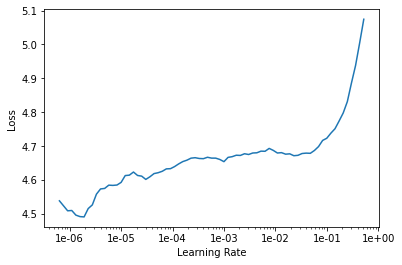

In [52]:
learn.recorder.plot(skip_end=15)

In [53]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.717441,4.531813,0.268394,29:10


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [59]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because he was a xxbos This movie it was an example of the two problems with the roles . It was a very easy " This game " . In reality mostly , i found it a
I liked this movie because i was young in this movie , i was too critic to watch it , i think it was a decent movie . The plot is really good , and i was n't given any emotion at all .


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
path = untar_data(URLs.IMDB)

In [75]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


IndexError: ignored

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( xxmaj ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( xxmaj mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go",neg
"xxbos i felt duty bound to watch the 1983 xxmaj timothy xxmaj dalton / xxmaj zelah xxmaj clarke adaptation of "" xxmaj jane xxmaj eyre , "" because i 'd just written an article about the 2006 xxup bbc "" xxmaj jane xxmaj eyre "" for xxunk . \n\n xxmaj so , i approached watching this the way i 'd approach doing homework . \n\n i was irritated at first",pos
"xxbos xxmaj no , this is n't a sequel to the fabulous xxup ova series , but rather a remake of the events that occurred after the death of xxmaj xxunk ( and the disappearance of xxmaj woodchuck ) . xxmaj it is also more accurate to the novels that inspired this wonderful series , which is why characters ( namely xxmaj orson and xxmaj xxunk ) are xxunk ,",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.310078,0.197204,0.926960


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.255913,0.169186,0.937800


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.223174,0.165679,0.939600


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.240424,0.155204,0.943160
2,0.217462,0.153421,0.943960


In [0]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([7.5928e-04, 9.9924e-01]))

In [0]:


# Review
- IMDB에서 positive, negative를 확인할 때의 문제점 
  - neural networks는 weight matrics를 random setting에서 시작하는데, 이는 model을 학습시키기에 data양이 절대적으로 부족하다. 
  - 언어의 특성상, sarcasm, 변형 등 표현이 너무 다양함은 그 어려움을 배가시킨다.

  - 따라서 tranfer learning을 통해 그 문제를 어느 정도 해결한다.(trick)

## Transfer Learning in NLP
  - computer vision과 같이 Pre-trained model을 이용한다.
  - Imagenet에서는, pretrained model을 만들고 fine-tuning을 하여 specifict dataset에 대한 정확도를 높인다.

  - NLP에서는, 문장의 다음 단어를 예측하는 language model라는 pretrained model을 사용한다.
  - 이전에는 nlp에서 ngram을 사용했는데, 예측할 수 있는 단어 수(정보)가 별로 없는 등 효과가 좋지 않았지만, neural net에서는 다음 단어에 대해 매우 많은 종류의 단어들을 예측할 수 있다.
  - 더 나아가, yes or no 등의 single bit 정도의 예측 뿐만 아니라, 얼마나 영어를 잘하나 등과 같은 깊은 의미까지 다룰 수 있게 되었다.
  ### Wikitext 103
  - wikitext103 dataset이라는 wikipdia의 preprocessed model을 사용한다.
  - 이를 통해 wikipedia article들에서의 다음 단어들을 예측할 수 있다. 
  - nlp에서의 좋은 model을 갖는다는 것은 실제 세계가 어떻게 돌아가는지, 무엇인지 등을 이해하는데 도움이 된다.

  - 따라서 우리는 imageNet에서 pre-trained model을 사용한 것과 같이 다음 단어를 예측할 수 있을 뿐만 아니라 언어와 그것이 무엇을 의미한느지를 이해하는 Wikitext model을 가져와 사용할 것이다.
  - 그리고 이를 활용하여 movie reviews에서 next word를 예측할 수 있는 새로운 language model을 만들 것이다.

    - Pretrained model을 통해 우리는 `my favortie actor is Tom ____?'등을 예측할 수 있다.
    - Self-supervised learning : Pre-training과 fine-tuning에서 우리는 label들을 필요로 하지 않는다.
      - label을 우리가 지정해주는 것이 아니라, dataset자체에 이미 내장되어 있기 때문이다.

  - wkikitext의 pre-trained 를 활용해도 우리의 dataset인 target corpus에 fine-tuning을 하면 slang, 축약어 등이 들어간 문장들 역시 높은 성공율로 예측할 수 있다.